In [ ]:
import torch
from torch.distributions import Normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

In [ ]:
n_epochs = 3
batch_size_train = 60000
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
# example_data.shape, example_targets
test_data = torch.flatten(example_data, start_dim=1)
test_data.shape

torch.Size([10000, 784])

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
# example_data.shape, example_targets
train_data = torch.flatten(example_data, start_dim=1)
train_data.shape

torch.Size([60000, 784])

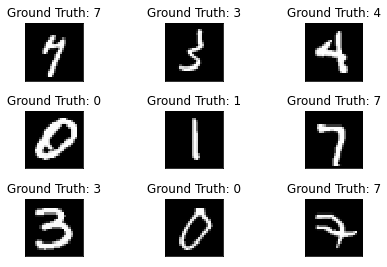

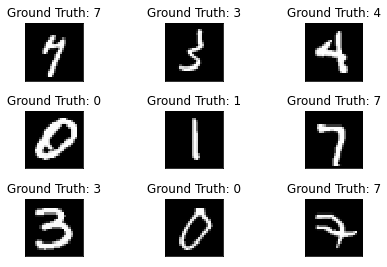

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn # submodule for neural network building blocks

class AutoEncoder(nn.Module):
    """
    AutoEncoder with fully connected layers.

    ----------
    input_shape
      shape of the input data
    latent_dim
      size of the latent dimension
    """
    def __init__(self, input_shape, latent_dim = 128):
      super().__init__()
      # five fully connected layers for encoder (input_shape -> latent_dim)
      offset = (input_shape - latent_dim) // 5
      self.encoder_l1 = nn.Linear(in_features=input_shape, out_features= input_shape // 2)
      self.encoder_l2 = nn.Linear(in_features=input_shape // 2 , out_features = input_shape // 4)
      self.encoder_l3 = nn.Linear(in_features=input_shape // 4 , out_features=input_shape // 8)
      self.encoder_l4 = nn.Linear(in_features=input_shape // 8 , out_features=input_shape // 16)
      self.encoder_l5 = nn.Linear(in_features=input_shape // 16 , out_features=input_shape //32)

      # five fully connected layers for decoder (128 -> input_shape)
      self.decoder_l1 = nn.Linear(in_features=input_shape // 32, out_features=input_shape // 16)
      self.decoder_l2 = nn.Linear(in_features=input_shape // 16, out_features=input_shape // 8)
      self.decoder_l3 = nn.Linear(in_features=input_shape // 8, out_features=input_shape // 4)
      self.decoder_l4 = nn.Linear(in_features=input_shape // 4, out_features=input_shape // 2)
      self.decoder_l5 = nn.Linear(in_features=input_shape // 2, out_features=input_shape)


    def forward(self, x):

      latent = self.run_encoder(x)
      x_hat = self.run_decoder(latent)
      return x_hat

    def run_encoder(self, x):
      # Runs encoder
      output_1 = F.relu(self.encoder_l1(x)) # relu adds non linearity
      output_2 = F.relu(self.encoder_l2(output_1))
      output_3 = F.relu(self.encoder_l3(output_2))
      output_4 = F.relu(self.encoder_l4(output_3))
      latent = F.relu(self.encoder_l5(output_4)) # this our latent representation
      return latent

    def run_decoder(self, latent):
      # Runs decoder
      output_1 = F.relu(self.decoder_l1(latent))
      output_2 = F.relu(self.decoder_l2(output_1))
      output_3 = F.relu(self.decoder_l3(output_2))
      output_4 = F.relu(self.decoder_l4(output_3))
      x_hat = F.relu(self.decoder_l5(output_4)) # reconstructed images
      return x_hat

In [ ]:

# get the shape of our input data
image_shape = train_data.shape[1]
print(image_shape)

# initialize AutoEncoder
model = AutoEncoder(input_shape = image_shape)

# move the model onto GPU
model.cuda()

model.train()

784


AutoEncoder(
  (encoder_l1): Linear(in_features=784, out_features=392, bias=True)
  (encoder_l2): Linear(in_features=392, out_features=196, bias=True)
  (encoder_l3): Linear(in_features=196, out_features=98, bias=True)
  (encoder_l4): Linear(in_features=98, out_features=49, bias=True)
  (encoder_l5): Linear(in_features=49, out_features=24, bias=True)
  (decoder_l1): Linear(in_features=24, out_features=49, bias=True)
  (decoder_l2): Linear(in_features=49, out_features=98, bias=True)
  (decoder_l3): Linear(in_features=98, out_features=196, bias=True)
  (decoder_l4): Linear(in_features=196, out_features=392, bias=True)
  (decoder_l5): Linear(in_features=392, out_features=784, bias=True)
)

In [ ]:
# Training loop from:
# https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

import torch.optim as optim
import random

# make our training data loader

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) ])),
  batch_size=8000, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

train_data = torch.flatten(example_data, start_dim=1)


# mean-squared error loss
mse = nn.MSELoss()

# create an optimizer object
optimizer = optim.SGD(model.parameters(), lr=1e-2)

n_epochs = 10



for epoch in range(n_epochs):
    loss = 0
    training_data = []
    temp = []
    i = 0
    j = 0
    # random.shuffle(train_data)
    for batch_features in train_data:
        j += 1
        if j == 1000:
          training_data.append(temp)
          temp = []
          j = 1
        temp.append(batch_features)


    for i in range (8):
        for batch_features in training_data[i]:
            # put data onto GPU
            batch_features = batch_features.cuda()

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(batch_features)

            # compute training reconstruction loss
            train_loss = mse(outputs, batch_features)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss

        loss = loss / len(training_data[i])

        if i %5 ==0:
          # display the epoch training loss every 5 epochs
          print("epoch : {}/{}, batch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, i + 1, 20, loss))

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, n_epochs, loss))

epoch : 1/10, batch : 1/20, loss = 0.972960
epoch : 1/10, batch : 6/20, loss = 0.890000
epoch : 1/10, loss = 0.889048
epoch : 2/10, batch : 1/20, loss = 0.862136
epoch : 2/10, batch : 6/20, loss = 0.878376
epoch : 2/10, loss = 0.888360
epoch : 3/10, batch : 1/20, loss = 0.861782
epoch : 3/10, batch : 6/20, loss = 0.876873
epoch : 3/10, loss = 0.884763
epoch : 4/10, batch : 1/20, loss = 0.856516
epoch : 4/10, batch : 6/20, loss = 0.849142
epoch : 4/10, loss = 0.857445
epoch : 5/10, batch : 1/20, loss = 0.834592
epoch : 5/10, batch : 6/20, loss = 0.846059
epoch : 5/10, loss = 0.853348
epoch : 6/10, batch : 1/20, loss = 0.829527
epoch : 6/10, batch : 6/20, loss = 0.838699
epoch : 6/10, loss = 0.843477
epoch : 7/10, batch : 1/20, loss = 0.821904
epoch : 7/10, batch : 6/20, loss = 0.824869
epoch : 7/10, loss = 0.827201
epoch : 8/10, batch : 1/20, loss = 0.803289
epoch : 8/10, batch : 6/20, loss = 0.800262
epoch : 8/10, loss = 0.798456
epoch : 9/10, batch : 1/20, loss = 0.780506
epoch : 9/10

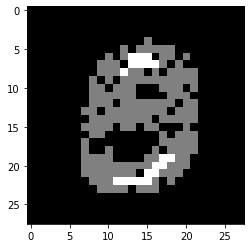

In [ ]:
# putting the model into eval() model
model.eval()

# visualizing the output of the train set
image_idx = 15

image = test_data[image_idx].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28,28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray') # reconstructed image

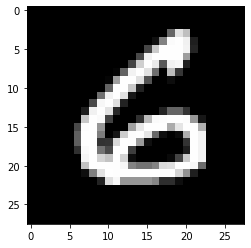

In [ ]:
plt.imshow(image.cpu().reshape((28,28)), cmap='gray') # original input image

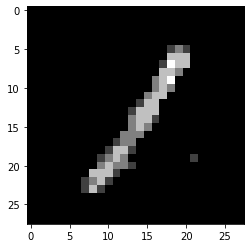

In [ ]:
# Visualizing test images
image_idx = 110

image = test_data[image_idx].cuda()
x_hat = model(image)
x_hat = x_hat.detach().cpu().numpy().reshape((28,28))
x_hat = np.around(x_hat)

plt.imshow(x_hat, cmap='gray')

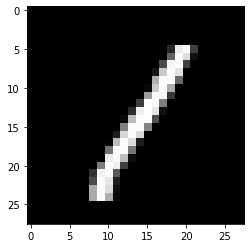

In [ ]:
plt.imshow(image.cpu().reshape((28,28)), cmap='gray') # ground truth test image

In [ ]:
test_reconstructed = []
test = []

for data in test_data:
  image = data.cuda()
  test.append(image)
  x_hat = model(image)
  x_hat = x_hat.cuda()
  test_reconstructed.append(x_hat)

print(len(test_reconstructed))

10000


In [ ]:
accumulated_score = 0
for i in range(len(test)):
  score = mse(test[i], test_reconstructed[i])
  accumulated_score += score

accumulated_score = accumulated_score / 10000

print(score)

tensor(0.8404, device='cuda:0', grad_fn=<MseLossBackward>)
